In [1]:
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import pandas as pd
import mdtraj as md
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


# coordinates

In [2]:
liganded_topfile = 'data/liganded_ca.pdb'
complex_topfile = 'data/complex_ca.pdb'
liganded_top = md.load(liganded_topfile)
complex_top = md.load(complex_topfile)
from glob import glob
liganded_list = glob('data/liganded/ca*.xtc')
complex_list = ['data/complex100/ca{}.xtc'.format(i) for i in range(2,12)]

In [3]:
v1_2 = range(99,153)#top.topology.select('resi 99 to 152 and name CA')
b_sheet = list(range(89,92))+list(range(168,171))+list(range(385,387))+list(range(394,396))
#top.topology.select('resi 89 to 92 or resi 168 to 171 or resi 385 to 387 or resi 394 to 396 and name CA')
a1 = range(69,85)#top.topology.select('resi 69 to 85 and name CA')
v3 = range(265,294)#top.topology.select('resi 265 to 294 and name CA')

In [4]:
def compute_center_of_mass(traj,atom_indices=None):
    if atom_indices==None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)
    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

# FEL

In [31]:
liganded_v3 = computer_vector(liganded_list,liganded_top,indices1=b_sheet,indices2=[279])
complex_v3 = computer_vector(complex_list,complex_top,indices1=b_sheet,indices2=[279])
liganded_v12 = computer_vector(liganded_list,liganded_top,indices1=b_sheet,indices2=v1_2)
complex_v12 = computer_vector(complex_list,complex_top,indices1=b_sheet,indices2=v1_2)

In [61]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(liganded_v3)
liganded_x = pca.transform(liganded_v3)
pca = PCA()
pca.fit(liganded_v12)
liganded_y = pca.transform(liganded_v12)
pca = PCA()
pca.fit(complex_v3)
complex_x = pca.transform(complex_v3)
pca = PCA()
pca.fit(complex_v12)
complex_y = pca.transform(complex_v12)

In [62]:
data = [[liganded_x,liganded_y],[complex_x,complex_y]]

In [47]:
print(max(liganded_y[:,0]),min(liganded_y[:,0]))
print(max(complex_y[:,0]),min(complex_y[:,0]))

2.7902119304761555 -1.8893438645301954
2.2556714489038283 -1.770989636087955


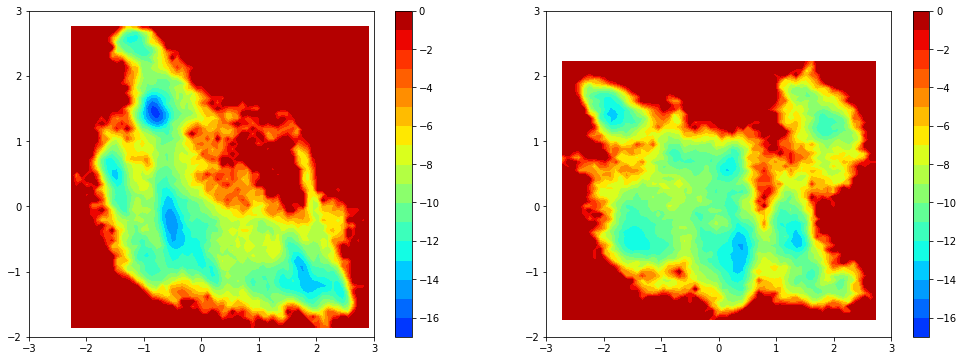

In [66]:
figure(figsize=(17,6))
for i,d in enumerate(data):
    subplot(1,2,i+1)
    z,xedge, yedge = np.histogram2d(d[0][:,0], d[1][:,0], bins=60)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    zmin_nonzero = np.min(z[np.where(z > 0)])
    z = np.maximum(z, zmin_nonzero)
    F = -2.479*np.log(z)
    F -= np.max(F)
    F = np.minimum(F, 0)
    colors = [(cm.jet(i)) for i in range(40,250)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=300)
    extent = [-2, 3, -3, 3]
    contourf(x,y,F.T, 100, cmap=cmap,levels=[i for i in range(-17,0,1)]+[0])
    clb = colorbar()
    xlim(-3,3)
    ylim(-2,3)
#savefig('liganded_tica_FEL.png',dpi=720,bbox_inches='tight')

In [39]:
a = coor.tica(complex_v3)
b = coor.tica(complex_v12)
a = a.get_output()
b = b.get_output()

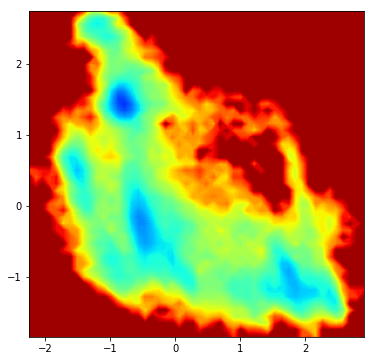

In [40]:
figure(figsize=(6,6))
z,xedge, yedge = np.histogram2d(liganded_x[:,0], liganded_y[:,0], bins=50)
x = 0.5*(xedge[:-1] + xedge[1:])
y = 0.5*(yedge[:-1] + yedge[1:])
zmin_nonzero = np.min(z[np.where(z > 0)])
z = np.maximum(z, zmin_nonzero)
F = -2.479*np.log(z)
F -= np.max(F)
F = np.minimum(F, 0)
colors = [(cm.jet(i)) for i in range(40,250)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=300)
extent = [yedge[0], yedge[-1], xedge[0], xedge[-1]]
contourf(x,y,F.T, 100, cmap=cmap, extent=extent,)#levels=[i for i in range(-15,0,1)]+[0]
#savefig('complex_tica_FEL.png',dpi=720,bbox_inches='tight')

# features

In [7]:
def plot_angle(traj_files,top,ax,atom_indices1,atom_indices2,atom_indices3,name='',lw=None,color=None,alpha=0.5,ann=None):
    from MDAnalysis.lib.distances import calc_angles
    angles_list = []
    if lw==None:
        lw = [1] * len(traj_files)
    elif isinstance(lw,(float,int)):
        lw = [lw] * len(traj_files)
    elif isinstance(lw,list) and len(lw) == len(traj_files):
        pass
    else:
        raise ValueError
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)
        traj.superpose(top)
        coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
        coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
        coords3 = compute_center_of_mass(traj,atom_indices3).astype(np.float32)     
        angles = calc_angles(coords1,coords2,coords3)
        angles_list.append(angles)
        ax.plot(angles,label='{}{}'.format(name,i),lw=lw[i],alpha=alpha,color=color)
        if ann and i in ann[0]:
            ann_index = ann[0].index(i)
            x = ann[1][ann_index]
            y = angles[x]
            ann_label = ann[2][ann_index]     
            ax.annotate(s=ann_label,xy=(x,y),arrowprops={'arrowstyle':'->'},fontsize=24,color='black')
    return angles_list

In [8]:
def plot_distance(traj_files,top,ax,atom_indices1,atom_indices2,name='',lw=None,color=None,alpha=0.5,ann = None):
    distance_list = []
    from MDAnalysis.lib.distances import calc_bonds
    if lw==None:
        lw = [1] * len(traj_files)
    elif isinstance(lw,(int,float)):
        lw = [lw] * len(traj_files)
    elif isinstance(lw,list) and len(lw) == len(traj_files):
        pass
    else:
        raise ValueError   
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)  
        traj.superpose(top)
        coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
        coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
        distance = calc_bonds(coords1,coords2)
        distance_list.append(distance)
        ax.plot(distance,label='{}{}'.format(name,i),lw=lw[i],alpha=alpha,color=color)
        if ann and i in ann[0]:
            ann_index = ann[0].index(i)
            x = ann[1][ann_index]
            y = distance[x]
            ann_label = ann[2][ann_index]
            ax.annotate(s=ann_label,xy=(x,y),arrowprops={'arrowstyle':'->'},fontsize=24,color='black')
    return distance_list

In [9]:
def plot_RMSD(traj_files,top,ax,name=''):
    rmsd_list = []
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)
        rmsd = md.rmsd(traj.superpose(reference=top),reference=top)
        rmsd_list.append(rmsd)
        #ax.plot(rmsd,label='{}{}'.format(name,i),lw=1,alpha=0.5)
    return rmsd_list

ModuleNotFoundError: No module named 'MDAnalysis'

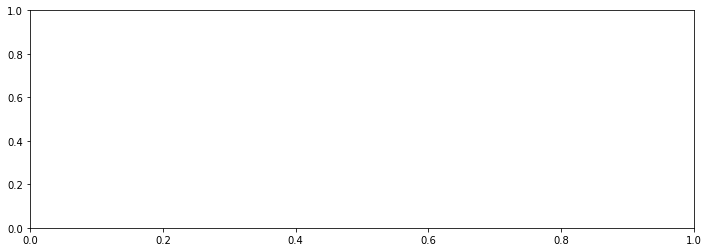

In [10]:
figure(figsize=(15,4))
gs = GridSpec(1,5)
subplot(gs[0,:4])
ax = gca()
angles_all = plot_angle(liganded_list,liganded_top,ax,v1_2,b_sheet,a1,alpha=0.5,color='b',lw=0.4)
angles_all += plot_angle(complex_list,complex_top,ax,v1_2,b_sheet,a1,alpha=0.5,color='g',lw=0.4)
lines = ax.get_lines()
ax.legend((lines[0],lines[12]),('$apo$','CD4-bound'),fontsize=12,loc=1,ncol=2,markerscale=10)
xlim(0,10000)
xticks(range(0,10001,2000),range(0,101,20),fontsize=12)
ylim(0.8,3.2)
yticks(arange(1,3.2,0.5),fontsize=12)
xlabel('Time (ns)',fontsize=14)
ylabel('V1/V2-α1 angle (rad)',fontsize=14)
subplot(gs[0,4])
data = [np.array(angles_all).flatten(),np.array(angles_all[:10]).flatten(),np.array(angles_all[10:]).flatten()]
h1 = hist(data,range=(0.8,3.2),bins=500,color=['gray','b','g'],label='angle',histtype='stepfilled',alpha=0.5,orientation='horizontal')
ylim(0.8,3.2)
xticks([])
yticks([])

subplots_adjust(wspace =0.01)
#savefig('fig2-1.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
figure(figsize=(15,4))
gs = GridSpec(1,5)
subplot(gs[0,:4])
ax = gca()
distance_all = plot_distance(liganded_list,liganded_top,ax,b_sheet,v3,alpha=0.6,lw=0.4,color='b')
distance_all += plot_distance(complex_list,complex_top,ax,b_sheet,v3,alpha=0.6,lw=0.4,color='g')
lines = ax.get_lines()
ax.legend((lines[4],lines[15]),('$apo$','CD4-bound'),fontsize=12,loc=1,ncol=2,markerscale=10)
xlim(0,10000)
xticks(range(0,10001,2000),range(0,101,20),fontsize=12)
ylim(1.3,3.5)
yticks(arange(1.5,3.5,0.5),fontsize=12)
xlabel('Time (ns)',fontsize=14)
ylabel('V3-bridging distance (nm)',fontsize=14)
subplot(gs[0,4])
data = [np.array(distance_all).flatten(),np.array(distance_all[:10]).flatten(),np.array(distance_all[10:]).flatten()]
h2 = hist(data,range=(1.3,3.5),bins=500,color=['gray','b','g'],label='distance',histtype='stepfilled',alpha=0.5,orientation='horizontal')
ylim(1.3,3.5)
ax = gca()
ax.set_xticks([])
ax.set_yticks([])
subplots_adjust(wspace =0.01)
savefig('fig2-2.png', format='png',dpi=720,bbox_inches="tight")

In [5]:
def neartest_to_mass_center(top,indices=None):
    coords_mass_center = compute_center_of_mass(top,indices).astype(np.float32)[0]
    atoms_coords = np.take(top.xyz, indices, axis=1)[0]
    distance = np.linalg.norm(atoms_coords - coords_mass_center,axis=1)
    index = np.where(distance==np.min(distance))
    return index[0][0]

In [6]:
def computer_vector(traj_list,top,indices1=None,indices2=None):
    for t in traj_list:
        traj = md.load(t,top=top)
        traj.superpose(reference=top)
        try:
            vector = np.concatenate((vector,compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)))
        except:
            vector = compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)

    return vector

In [16]:
v3 = computer_vector(liganded_list,liganded_top,indices1=b_sheet,indices2=[279])
v3 = np.concatenate((v3,computer_vector(complex_list,liganded_top,indices1=b_sheet,indices2=[279])))
v12 = computer_vector(liganded_list,liganded_top,indices1=b_sheet,indices2=v1_2)
v12 = np.concatenate((v12,computer_vector(complex_list,liganded_top,indices1=b_sheet,indices2=v1_2)))

In [12]:
from sklearn.cluster import KMeans
ncluster = 5
kmeans_v3 = KMeans(n_clusters=ncluster, random_state=0).fit(v3)
kmeans_v12 = KMeans(n_clusters=4, random_state=0).fit(v12)


In [9]:
def find_nersest_to_center(center,data):
    distance = np.linalg.norm(data-center,axis=1)
    index = np.where(distance == np.min(distance))[0][0]
    traj_index = index//10001
    frame = index%10001
    return (traj_index,frame)

In [10]:
print(('v3','v12'))
for i in range(ncluster):
    print((i,find_nersest_to_center(kmeans_v3.cluster_centers_[i],v3),find_nersest_to_center(kmeans_v12.cluster_centers_[i],v12)))

('v3', 'v12')
(0, (17, 9003), (0, 5416))
(1, (19, 4092), (5, 6612))
(2, (1, 7202), (19, 8581))
(3, (10, 5249), (6, 6575))
(4, (9, 3030), (16, 4216))
(5, (3, 1644), (11, 988))
(6, (2, 9911), (9, 4697))
(7, (15, 2635), (15, 9843))
(8, (4, 6047), (15, 1567))
(9, (6, 6270), (7, 5098))
(10, (16, 7684), (18, 2771))
(11, (0, 7815), (3, 8093))
(12, (13, 9713), (10, 672))
(13, (3, 7130), (8, 3168))
(14, (9, 2157), (2, 5829))
(15, (18, 7291), (19, 4910))
(16, (14, 8746), (14, 7774))


In [13]:
v3_ = [[] for i in range(ncluster)]
for j,i in enumerate(kmeans_v3.labels_):
    v3_[i].append(v3[j])
v3_ = np.array(v3_)
v12_ = [[] for i in range(4)]
for j,i in enumerate(kmeans_v12.labels_):
    v12_[i].append(v12[j])
v12_ = np.array(v12_)

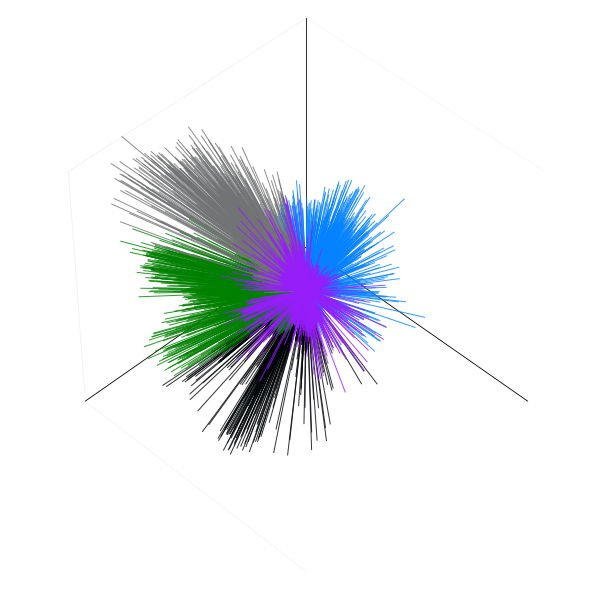

In [27]:
fig = figure(figsize=(8,8))
ax = Axes3D(fig)
#colors = get_cmap('viridis').colors+get_cmap('inferno').colors+get_cmap('plasma').colors+get_cmap('magma').colors
#colors = [colors[i*int(len(colors)/30)] for i in range(ncluster)]
# colors = ['#000305','green','#0582ff','#727374','#961efa','#13fbe5','#214f0c','#244460','#5f4e5f','#e98301','#d601e9',
#          '#ecd6b1','#d1fb84','#373958','black','blue','#79e2ac']
#color = []
for i,v_ in enumerate(v3_):
    data = np.array(v_[::100])
    ax.quiver([0]*len(data),[0]*len(data),[0]*len(data),data[:,0],data[:,1],data[:,2],length=0.025,pivot='tip',alpha=.8,lw=1,color=colors[i])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.grid(b=False)
tmp_planes = ax.zaxis._PLANES
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax.yaxis._PLANES
ax.yaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax.xaxis._PLANES
ax.xaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
ax.view_init(45,135)
savefig('V3_vector.png',format='png',dpi=720,bbox_inches="tight")

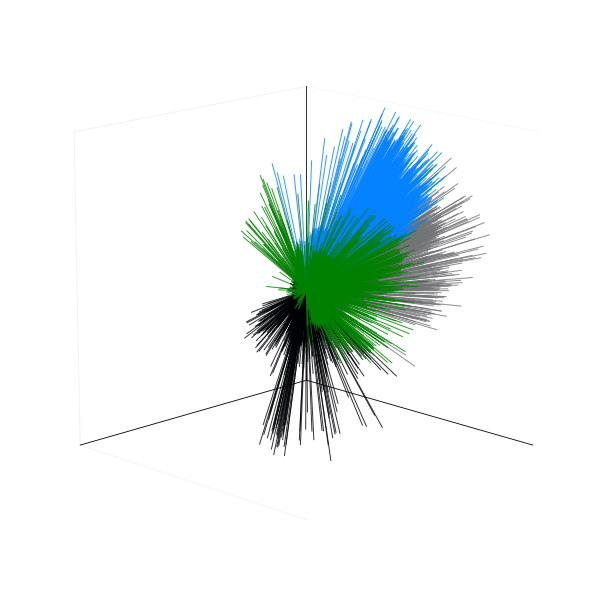

In [17]:
fig=figure(figsize=(8,8))
ax = Axes3D(fig)
# colors = get_cmap('viridis').colors+get_cmap('inferno').colors+get_cmap('plasma').colors+get_cmap('magma').colors
# colors = [colors[i*int(len(colors)/30)] for i in range(ncluster)]
colors = ['#000305','green','#0582ff','#727374','#961efa','#13fbe5','#214f0c','#244460','#5f4e5f','#e98301','#d601e9',
         '#ecd6b1','#d1fb84','#373958','black','blue','#79e2ac']
for i,v_ in enumerate(v12_):
    data = np.array(v_[::100])
    ax.quiver([0]*len(data),[0]*len(data),[0]*len(data),data[:,0],data[:,1],data[:,2],length=0.025,pivot='tip',alpha=.8,lw=1,color=colors[i])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(b=False)
tmp_planes = ax.zaxis._PLANES
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax.yaxis._PLANES
ax.yaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax.xaxis._PLANES
ax.xaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
ax.view_init(15,135)
savefig('v12_vector.png',format='png',dpi=720,bbox_inches="tight")

In [ ]:
def find_x_value(x,y,region):
    values = []
    for r in region:
        x1 = min(r)
        x2 = max(r)
        ix1 = np.where(x>x1)[0][0]
        ix2 = np.where(x<x2)[0][-1]
        m_index = np.where(y == np.max(y[ix1:ix2]))
        m_x = x[m_index][0]
        values.append(m_x)
    return values

In [ ]:
angle_m = find_x_value(data_x1,data_y1,[(1.5,1.8),(2.0,2.3),(2.2,2.5),(2.5,3.0)])
distance_m = find_x_value(data_x2,data_y2,[(1.5,1.8),(1.8,2.0),(2.0,2.25),(2.25,2.5),(2.5,2.8)])

# MSM

In [19]:
def compute_angles(traj,atom_indices1,atom_indices2,atom_indices3,cossin=True):
    from MDAnalysis.lib.distances import calc_angles
    traj.superpose(traj, frame=0)
    coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
    coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
    coords3 = compute_center_of_mass(traj,atom_indices3).astype(np.float32)
    angles = calc_angles(coords1,coords2,coords3)
    #if cossin:
        #rad = np.dstack((np.cos(angles), np.sin(angles)))
        #rad = rad.reshape(rad.shape[0], rad.shape[1]*rad.shape[2])
    #else:
        #rad = angles
   # print rad
    return np.vstack(angles.astype(np.float32))#rad[0].astype(np.float32)

In [20]:
def compute_distance(traj,atom_indices1,atom_indices2):
    from MDAnalysis.lib.distances import calc_bonds
    traj.superpose(traj, frame=0)
    coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
    coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
    distance = calc_bonds(coords1,coords2)
    return np.vstack(distance.astype(np.float32))

In [21]:
def RMSD(traj,top_file):
    traj.superpose(traj, frame=0)
    top = md.load(top_file)
    rmsd = md.rmsd(traj.superpose(reference=top),reference=top)
    return np.vstack(rmsd.astype(np.float32))

In [22]:
def computer_vector_(traj,indices1=None,indices2=None):
    traj.superpose(traj, frame=0)
    try:
        vector = np.concatenate((vector,compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)))
    except:
        vector = compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)
    return vector.astype(np.float32)

In [26]:
feat = coor.featurizer(liganded_topfile)
feat.add_custom_func(computer_vector_,3,b_sheet,v1_2)
#feat.add_custom_func(RMSD,1,liganded_topfile)
#feat.add_custom_func(compute_distance,1,b_sheet,v3)
feat.add_custom_func(computer_vector_,3,b_sheet,[279])

In [28]:
# complex_inp = coor.source(complex_list, complex_feat)
# liganded_inp = coor.source(liganded_list, liganded_feat)
# inp = coor.combine_sources([complex_inp,liganded_inp])
li_inp = coor.source(liganded_list,feat)
li_data = li_inp.get_output()
print('number of trajectories = ',li_inp.number_of_trajectories())
print('trajectory length = ',li_inp.trajectory_length(0))
print('trajectory time step = ',100.0 / (li_inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',li_inp.dimension())

number of trajectories =  10
trajectory length =  10001
trajectory time step =  0.01 ns
number of dimension =  6


In [41]:
# complex_inp = coor.source(complex_list, complex_feat)
# liganded_inp = coor.source(liganded_list, liganded_feat)
# inp = coor.combine_sources([complex_inp,liganded_inp])
co_inp = coor.source(complex_list,feat)
co_data = co_inp.get_output()
print('number of trajectories = ',co_inp.number_of_trajectories())
print('trajectory length = ',co_inp.trajectory_length(0))
print('trajectory time step = ',100.0 / (co_inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',co_inp.dimension())

number of trajectories =  10
trajectory length =  10001
trajectory time step =  0.01 ns
number of dimension =  6


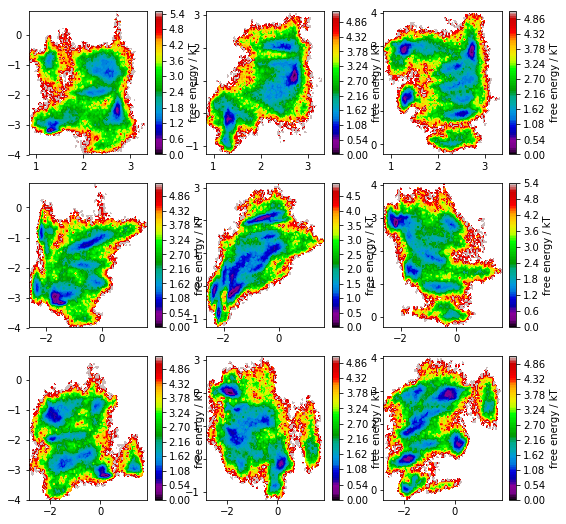

In [42]:
figure(figsize=(9,9))
for i in range(3):
    for j in range(3):
        subplot(3,3,i*3+j+1)
        ax = gca()
        mplt.plot_free_energy(np.vstack(li_data)[:,i], np.vstack(li_data)[:,3+j],ax=ax)
savefig('liganded_FEL.png',dpi=720,bbox_inches='tight')

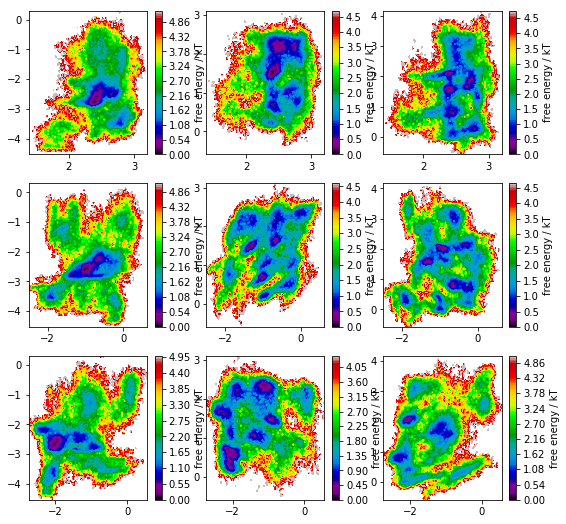

In [43]:
figure(figsize=(9,9))
for i in range(3):
    for j in range(3):
        subplot(3,3,i*3+j+1)
        ax = gca()
        mplt.plot_free_energy(np.vstack(co_data)[:,i], np.vstack(co_data)[:,3+j],ax=ax)
savefig('complex_FEL.png',dpi=720,bbox_inches='tight')

# TICA

In [ ]:
coor.tica()

In [ ]:
tica_obj = coor.tica(inp, lag=10, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())

In [ ]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

In [ ]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
figure(figsize(8,5))
ax1=plt.subplot(311)
x = dt*np.arange(Y[0].shape[0])
plot(x, Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks(np.arange(-8, 2, 2))
ax1=plt.subplot(312)
plot(x, Y[0][:,1]); ylabel('IC 2'); xticks([]);  yticks(np.arange(-6, 2, 2))
#ax1=plt.subplot(313)
#plot(x, Y[0][:,2]); xlabel('time / ns'); ylabel('IC 3'); yticks(np.arange(-4, 2, 2))
#save_figure('ic_trajs.png')

# Clustering

In [29]:
n_clusters = 250
clustering = coor.cluster_kmeans(data)

22-11-18 16:16:14 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=447 as n_clusters.


22-11-18 16:20:40 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [30]:
dtrajs = clustering.dtrajs

In [ ]:
np.shape(dtrajs)

In [ ]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

# Implied timescales

In [31]:
lags = range(0,50,5)
its = msm.timescales_msm(dtrajs, lags=lags, nits=10, errors=None, n_jobs=-1)

22-11-18 16:23:34 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[9] WARNING  Ignored error during estimation: row, column, and data array must all be the same length
22-11-18 16:24:04 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[10] WARNING  Estimation has failed at lagtimes: [0]. Details:
['Error at lag time 0: row, column, and data array must all be the same length']
22-11-18 16:24:04 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[10] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


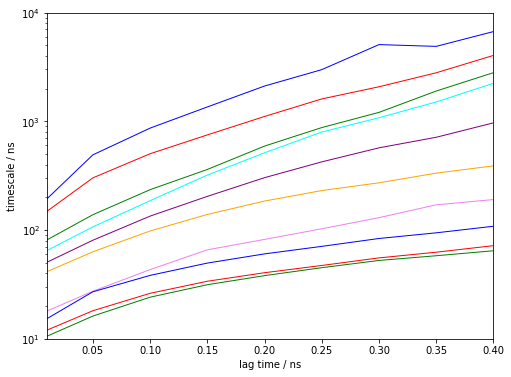

In [38]:
figure(figsize=(8,6))
ax=gca()
mplt.plot_implied_timescales(its, show_mean=False, ylog=True,  units='ns', linewidth=1,dt=0.01,ax=ax)
ylim(10,10**4)
savefig('its.png', format='png',dpi=720,bbox_inches="tight")

# Estimate MSM

In [198]:
msm_lag=1
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)
print(M.nstates)

fraction of states used =  1.0
fraction of counts used =  1.0
447


In [16]:
ck = M.cktest(4, mlags=10)

100%|██████████| 9/9 [00:20<00:00,  2.91s/it]                                 


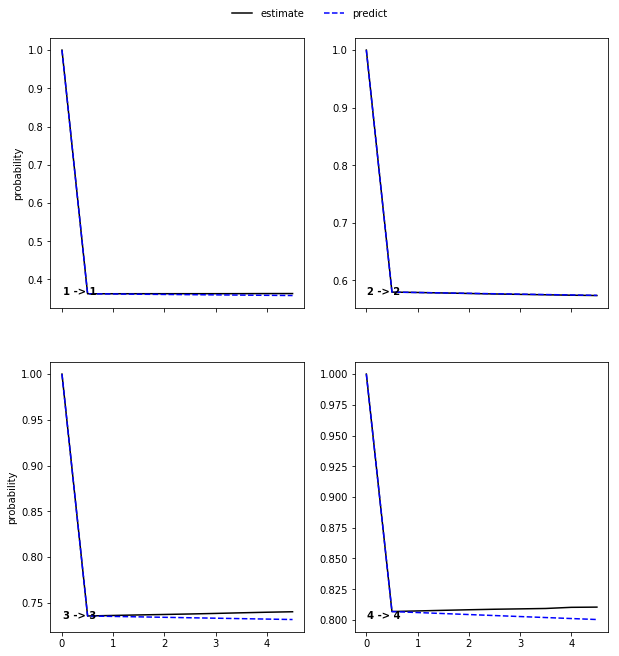

In [22]:
mplt.plot_cktest(ck, diag=True, figsize=(10,10), layout=(2,2), padding_top=0.05, y01=False, padding_between=0.2, dt=0.01, units='ns')
savefig('ck.png', format='png',dpi=720,bbox_inches="tight")

# bayesian MSM


In [39]:
msm_lag =5
M = msm.bayesian_markov_model(dtrajs,msm_lag )

100%|██████████| 100/100 [00:09<00:00, 11.86it/s]               


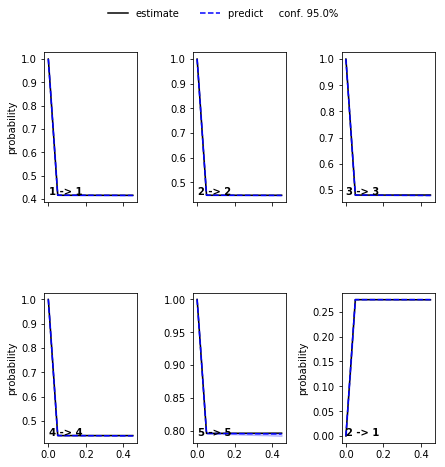

In [276]:
ck = M.cktest(5,mlags=10,show_progress=False)
mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,3), padding_top=0.1, y01=False, padding_between=0.6, dt=0.01, units='ns')
savefig('ck.png', format='png',dpi=720,bbox_inches="tight")

# Coarse-grained kinetic Model using a Hidden Markov Model

In [25]:
M.nstates

447

In [40]:
hmm = M.coarse_grain(5)

22-11-18 16:39:02 pyemma.msm.estimators.bayesian_msm.BayesianMSM[11] WARNING  Requested coarse-grained model with 5 metastable states at lag=5. The ratio of relaxation timescales between 5 and 6 states is only 1.2413813837736623 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.


In [41]:
hmm.stationary_distribution 

array([ 0.13770934,  0.63163011,  0.12484924,  0.05147917,  0.05433213])

/home/denglei/anaconda2/envs/python36/lib/python3.6/site-packages/pyemma/plots/networks.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  if (Dx / max_width > Dy / max_height):


(<matplotlib.figure.Figure at 0x7f325ad26390>, array([[0, 6],
        [5, 8],
        [0, 2],
        [5, 0],
        [8, 4]]))

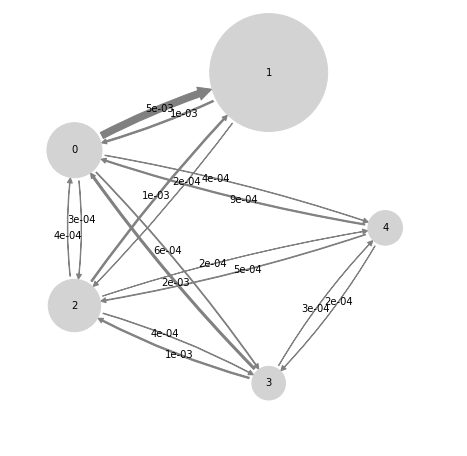

In [48]:
figure(figsize=(8,8))
ax = gca()
pos=np.array([[0,6],[5,8],[0,2],[5,0],[8,4]])
mplt.plot_markov_model(hmm,minflux=4e-6,pos=pos,arrow_curvature=0.5,arrow_scale=1.5,
                       max_width=1, max_height=0,ax=ax,state_colors='#D3D3D3',state_scale=2.0,)

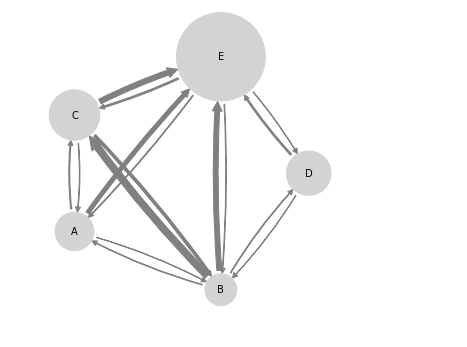

In [281]:
#pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])
#state_labels = ['A','B','C','D','E']
state_labels = ['C','E','A','B','D']
pos=np.array([[0,6],[5,8],[0,2],[5,0],[8,4]])
#pos=np.array([[0, 4],[8,4],[6, 0],[4,4],[2, 0]])

figure(figsize=(8,6))
ax = gca()
mplt.plot_markov_model(hmm,minflux=4e-6,pos=pos,state_labels=state_labels,arrow_curvature=0.5,arrow_labels=None,arrow_scale=1.5,
                       max_width=1, max_height=0,ax=ax,state_colors='#D3D3D3',state_scale=2.0,)
print()
savefig('fig3.png', format='png',dpi=720,bbox_inches="tight")

In [248]:
sample = hmm.sample_by_observation_probabilities(6)

In [249]:
sample

array([ array([[   1, 7590],
       [  13,  925],
       [  17, 5146],
       [  17, 4522],
       [   6, 9502],
       [   1,  649]]),
       array([[   4, 9300],
       [  18, 6795],
       [  14, 8840],
       [   8, 1091],
       [  14, 2376],
       [  16, 1879]]),
       array([[   2, 4981],
       [   0, 6220],
       [   0, 9083],
       [   0, 8074],
       [   0, 7102],
       [   2, 6935]]),
       array([[   5, 7794],
       [  10,  558],
       [  10,  880],
       [  10,  498],
       [  10, 1464],
       [  13,  499]]),
       array([[  13, 4991],
       [  13, 7647],
       [  13, 8763],
       [  13, 5039],
       [  13, 6162],
       [  13, 8091]])], dtype=object)

In [ ]:
#pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])
#state_labels = ['A','B','C','D','E']
state_labels = ['A','E','D','C','B']
#pos=np.array([[0, 4], [2, 0], [4,4], [6, 0],[8,4]])
pos=np.array([[0, 4],[8,4],[6, 0],[4,4],[2, 0]])
figure(figsize=(8,4))
ax = gca()
mplt.plot_markov_model(hmm,pos=pos, minflux=4e-4,state_labels=state_labels,arrow_label_format='%.3f',max_width=10, max_height=10,ax=ax,
                       state_colors='#D3D3D3',state_scale=1)
savefig('fig3.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
hmm.sample_by_observation_probabilities(10)

In [ ]:
hmm_ = M.hmm(5)

In [ ]:
pos=np.array([[0, 4], [2, 0], [4,4], [6, 0],[8,4]])
figure(figsize=(8,4))
ax = gca()
mplt.plot_markov_model(hmm_, pos=pos,minflux=4e-4, arrow_label_format='%.3f',max_width=10, max_height=10,ax=ax,
                       state_colors='#D3D3D3',state_scale=0.5)
#savefig('fig3.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
hmm.metastable_sets

In [ ]:
num = 0
for i in t:
    num += len(i)

In [ ]:
num

In [ ]:
def func(seq):
    none_polar = '''GAVLMI '''
    pos_elec = '''KRH'''
    neg_elec = '''DE'''
    none_elec = '''STCPNQ'''
    polar = pos_elec+neg_elec+none_elec 
    aromatic = '''FYW'''
    count = {'none_polar':0,'pos_elec':0,'neg_elec':0,'none_elec':0,'polar':0,'aromatic':0}
    for s in seq:
        if s in none_polar:
            count['none_polar'] += 1
        if s in pos_elec:
            count['pos_elec'] += 1
        if s in neg_elec:
            count['neg_elec'] += 1
        if s in none_elec:
            count['none_elec'] += 1
        if s in polar:
            count['polar'] += 1
        if s in aromatic:
            count['aromatic'] +=1
    return count
seq1 = '''IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEDNINVVEGNEQFISASKS
IVHPSYNSNTLNNDIMLIKLKSAASLNSRVASISLPTSCASAGTQCLISGWGNTKSSGTSYPDVLKCLKA
PILSDSSCKSAYPGQITSNMFCAGYLEGGKDSCQGDSGGPVVCSGKLQGIVSWGSGCAQKNKPGVYTKVC
NYVSWIKQTIASN
'''
seq2 = '''IVGGYECKPYSQPHQVSLNSGYHFCGGSLVNENWVVSAAHCYKSRVEVRLGEHNIKVTEGSEQFISSSRV
IRHPNYSSYNIDNDIMLIKLSKPATLNTYVQPVALPTSCAPAGTMCTVSGWGNTMSSTADSNKLQCLNIP
ILSYSDCNNSYPGMITNAMFCAGYLEGGKDSCQGDSGGPVVCNGELQGVVSWGYGCAEPGNPGVYAKVCI
FNDWLTSTMASY'''
_3btk = func(seq1)
_1bzx = func(seq2)